In [8]:
# Import All filenames in to dictionaries
import glob
dict_filename = {}
dict_filename['Intensity'] = glob.glob('./Intensity/*.csv')
dict_filename['Sleeping'] = glob.glob('./Sleeping/*.csv')
dict_filename['Resting'] = glob.glob('./Resting/*.csv')
dict_filename['AllStates'] = glob.glob('./All_states/*.csv')

In [9]:
# Showing all filenames
for state, filename in dict_filename.items():
    print(state + ' : ' + str(filename), end='\n\n')

Intensity : ['./Intensity/Subject01_2019-1-16_grouped_activity.csv', './Intensity/Subject02_2019-01-17_grouped_activity.csv', './Intensity/Subject03_2019-01-21_grouped_activity.csv', './Intensity/Subject09_2019-01-30_grouped_activity.csv', './Intensity/Subject08_2019-01-29_grouped_activity.csv', './Intensity/Subject05_2019-01-24_grouped_activity.csv', './Intensity/Subject06_2019-01-25_grouped_activity.csv', './Intensity/Subject04_2019-1-23_grouped_activity.csv', './Intensity/Subject10_2019-01-31_grouped_activity.csv', './Intensity/Subject07_2019-01-26_grouped_activity.csv']

Sleeping : ['./Sleeping/Subject10_2019-01-31_grouped_sleeping.csv', './Sleeping/Subject06_2019-01-25_grouped_sleeping.csv', './Sleeping/Subject09_2019-01-30_grouped_sleeping.csv', './Sleeping/Subject05_2019-01-24_grouped_sleeping.csv', './Sleeping/Subject07_2019-01-26_grouped_sleeping.csv', './Sleeping/Subject03_2019-01-21_grouped_sleeping.csv', './Sleeping/Subject04_2019-1-23_grouped_sleeping.csv', './Sleeping/Sub

# Training Random Forest Regression

## Training strategy
### 1. By states

    1.1.   Resting state
  
    1.2.   Sleeping state

    1.3.   Intensity state

### 2. All states

## Features


1.   Accelerometer(Vector), HR
2.   Freedson, HR
3.   Net Accelerometer, HR
4.   Net Accelerometer, Freedson, HR
5.   Abs(Accelerometer(Vector)), Freedson, HR
6.   Abs(Net Accelerometer), Freedson, HR






In [10]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Import LearningModel libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


# Ignoring warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fitbit


In [11]:
# Dict storing MAE on testing set from best estimator(from every features) of fitbit
features = [['HR_fitbit'], 
           ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'], 
           ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'HR_fitbit'], 
           ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']]
states = ['Resting', 'Sleeping', 'Intensity', 'AllStates']

mae_fitbit_results_score = {}
mae_fitbit_results_score['validation_set'] = {'Resting' : {}, 'Sleeping' : {}, 'Intensity' : {}, 'AllStates' : {}} 
mae_fitbit_results_score['testing_set'] = {'Resting' : {}, 'Sleeping' : {}, 'Intensity' : {}, 'AllStates' : {}} 

for each_feature in features :
    for state in states :
        #print({str(each_feature) : []})
        mae_fitbit_results_score['validation_set'][state][str(each_feature)] = {}
        mae_fitbit_results_score['testing_set'][state][str(each_feature)] = {}


## Resting state

In [12]:
# Resting states

# Reading all files into dataframe
resting_df = []
resting_df_training = []
resting_df_testing = []
X_trainingset = pd.DataFrame()
y_trainingset = pd.DataFrame()
X_testset = pd.DataFrame()
y_testset = pd.DataFrame()
for filename in dict_filename['Resting']:
    # Loading the dataset into dataframe
    temp_resting_df = pd.read_csv(filename)
    print('Filename : ' + filename)
    print('Usable data(Including Accel and Freedson) : ' + str(len(temp_resting_df[['HR_biosignalsplux', 'HR_fitbit', 'AX_empatica', 'AY_empatica', 'AZ_empatica', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded']].dropna())))
    
    temp_resting_df = temp_resting_df[['HR_biosignalsplux', 'HR_fitbit', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'AX_empatica', 'AY_empatica', 'AZ_empatica']].dropna()
    # Create a absolute feature from Accelerometer
    temp_resting_df[['VectorA_empatica_abs', 'AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs']] = np.abs(temp_resting_df[['VectorA_empatica', 'AX_empatica', 'AY_empatica', 'AZ_empatica']])
    X = temp_resting_df.loc[:, ['HR_fitbit', 'AX_empatica', 'AY_empatica', 'AZ_empatica', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'VectorA_empatica_abs', 'AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs']]
    y = temp_resting_df.loc[:, ['HR_biosignalsplux']]
    
    # Splitting data into training and testing set for each subject to prevent subject imbalanced
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=np.random.randint(0, 10))

    X_trainingset = X_trainingset.append(X_train, ignore_index=True)
    y_trainingset = y_trainingset.append(y_train, ignore_index=True)
    X_testset = X_testset.append(X_test, ignore_index=True)
    y_testset = y_testset.append(y_test, ignore_index=True)
    print('--->X Shape : ' + str(X.shape))
    print('--->y Shape : ' + str(y.shape))
    print('--->X_train Shape : ' + str(X_train.shape))
    print('--->y_train Shape : ' + str(y_train.shape))
    print('--->X_test Shape : ' + str(X_test.shape))
    print('--->y_test Shape : ' + str(y_test.shape))
    print('--->X_trainingset Shape : ' + str(X_trainingset.shape))
    print('--->y_trainingset Shape : ' + str(y_trainingset.shape))
    print('--->X_testset Shape : ' + str(X_testset.shape))
    print('--->y_testset Shape : ' + str(y_testset.shape))
    print('\n\n')
    resting_df.append(temp_resting_df)
  
# Final shape of training set and testing set
print('*************************************************')
print('Final shape of Training set')
print('--->X_trainingset Shape : ' + str(X_trainingset.shape))
print('--->y_trainingset Shape : ' + str(y_trainingset.shape))
print('Final shape of Testing set')
print('--->X_testset Shape : ' + str(X_testset.shape))
print('--->y_testset Shape : ' + str(y_testset.shape))
print('*************************************************')


Filename : ./Resting/Subject03_2019-01-21_grouped_resting.csv
Usable data(Including Accel and Freedson) : 165
--->X Shape : (165, 10)
--->y Shape : (165, 1)
--->X_train Shape : (132, 10)
--->y_train Shape : (132, 1)
--->X_test Shape : (33, 10)
--->y_test Shape : (33, 1)
--->X_trainingset Shape : (132, 10)
--->y_trainingset Shape : (132, 1)
--->X_testset Shape : (33, 10)
--->y_testset Shape : (33, 1)



Filename : ./Resting/Subject05_2019-01-24_grouped_resting.csv
Usable data(Including Accel and Freedson) : 0
--->X Shape : (0, 10)
--->y Shape : (0, 1)
--->X_train Shape : (0, 10)
--->y_train Shape : (0, 1)
--->X_test Shape : (0, 10)
--->y_test Shape : (0, 1)
--->X_trainingset Shape : (132, 10)
--->y_trainingset Shape : (132, 1)
--->X_testset Shape : (33, 10)
--->y_testset Shape : (33, 1)



Filename : ./Resting/Subject07_2019-01-26_grouped_resting.csv
Usable data(Including Accel and Freedson) : 158
--->X Shape : (158, 10)
--->y Shape : (158, 1)
--->X_train Shape : (126, 10)
--->y_train S

In [13]:
display(X_trainingset.head(3))
display(y_trainingset.head(3))

,HR_fitbit,AX_empatica,AY_empatica,AZ_empatica,VectorA_empatica,PA_lvl_VectorA_empatica_encoded,VectorA_empatica_abs,AX_empatica_abs,AY_empatica_abs,AZ_empatica_abs
0,73.0,0.429688,0.093750,-0.234063,0.498204,2.0,0.498204,0.429688,0.093750,0.234063
1,75.0,0.421875,0.007812,-0.266797,0.499225,2.0,0.499225,0.421875,0.007812,0.266797
2,81.0,0.460938,0.046562,-0.182812,0.498063,2.0,0.498063,0.460938,0.046562,0.182812


,HR_biosignalsplux
0,70.87
1,81.08
2,83.33


In [14]:
# Declare training features for trying the best features
features = [['HR_fitbit'],
           ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'], 
           ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'HR_fitbit'], 
           ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']]

# Hyperparameters settings
# Maximun depth for dividing into a new leaf
max_depth = np.arange(1, 2)
# Number of estimator for majority vote
n_estimators = [25, 50]
# Stop criteria
criterion = ['mae']


# Start training
params_dict = {'n_estimators' : n_estimators, 'criterion' : criterion, 'max_depth' : max_depth}
regressor_resting_dict = {}
for each_feature in features:
    print('Regressor : {0}'.format(each_feature))
    print(X_trainingset[each_feature].values.shape)
    rf_regressor = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params_dict, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=True, iid=True, return_train_score=True)
    regressor_resting_dict[str(each_feature)] = rf_regressor.fit(X_trainingset[each_feature].values, y_trainingset.values.reshape(-1))

Regressor : ['HR_fitbit']
(798, 1)
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Regressor : ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit']
(798, 4)
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.8s finished


Regressor : ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
(798, 2)
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Regressor : ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
(798, 3)
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.3s finished


Regressor : ['VectorA_empatica', 'HR_fitbit']
(798, 2)
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Regressor : ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
(798, 3)
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.5s finished


Regressor : ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
(798, 5)
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.9s finished


In [15]:
for regressor_name, regressor in regressor_resting_dict.items():
    temp_cv_results_ = pd.DataFrame(regressor.cv_results_)
    #print(temp_cv_results_.loc[temp_cv_results_['params'] == regressor.best_params_].loc[:, ['mean_test_score', 'std_test_score']])
    test_score_results = temp_cv_results_.loc[temp_cv_results_['params'] == regressor.best_params_].loc[:, ['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
    print('Test score(CV) : {0}'.format(test_score_results['mean_test_score'].values[0]))
    print('Std test score(CV) : {0}'.format(test_score_results['std_test_score'].values[0]))
    mae_fitbit_results_score['validation_set']['Resting'][str(regressor_name)]['MAE_mean_test_score'] = test_score_results['mean_test_score'].values[0]
    mae_fitbit_results_score['validation_set']['Resting'][str(regressor_name)]['MAE_std_test_score'] = test_score_results['std_test_score'].values[0]
    mae_fitbit_results_score['validation_set']['Resting'][str(regressor_name)]['MAE_mean_train_score'] = test_score_results['mean_train_score'].values[0]
    mae_fitbit_results_score['validation_set']['Resting'][str(regressor_name)]['MAE_std_train_score'] = test_score_results['std_train_score'].values[0]

    print('{0} : {1}'.format(regressor_name, regressor.best_score_))
    print('\n')

Test score(CV) : -5.015225207865046
Std test score(CV) : 1.1588076166459813
['HR_fitbit'] : -5.015225207865046


Test score(CV) : -5.007504939616467
Std test score(CV) : 1.1215438575824015
['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'] : -5.007504939616467


Test score(CV) : -5.017768689057921
Std test score(CV) : 1.1138608423636633
['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -5.017768689057921


Test score(CV) : -5.009161225849129
Std test score(CV) : 1.1102990557460821
['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -5.009161225849129


Test score(CV) : -5.014321388395989
Std test score(CV) : 1.1289276131645452
['VectorA_empatica', 'HR_fitbit'] : -5.014321388395989


Test score(CV) : -5.011837893171187
Std test score(CV) : 1.1227556486030381
['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -5.011837893171187


Test score(CV) : -5.014876607110543
Std test score(CV) : 1.1277445832219624
['AX_empatica_abs', 'AY_empatica

Regressor name : ['HR_fitbit']
RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=1,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAE on testing set : 4.8306679685116185
MAE_STD on testing set : 6.387004003044361



Regressor name : ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit']
RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=1,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAE on testing set : 4.7602244391515045
M

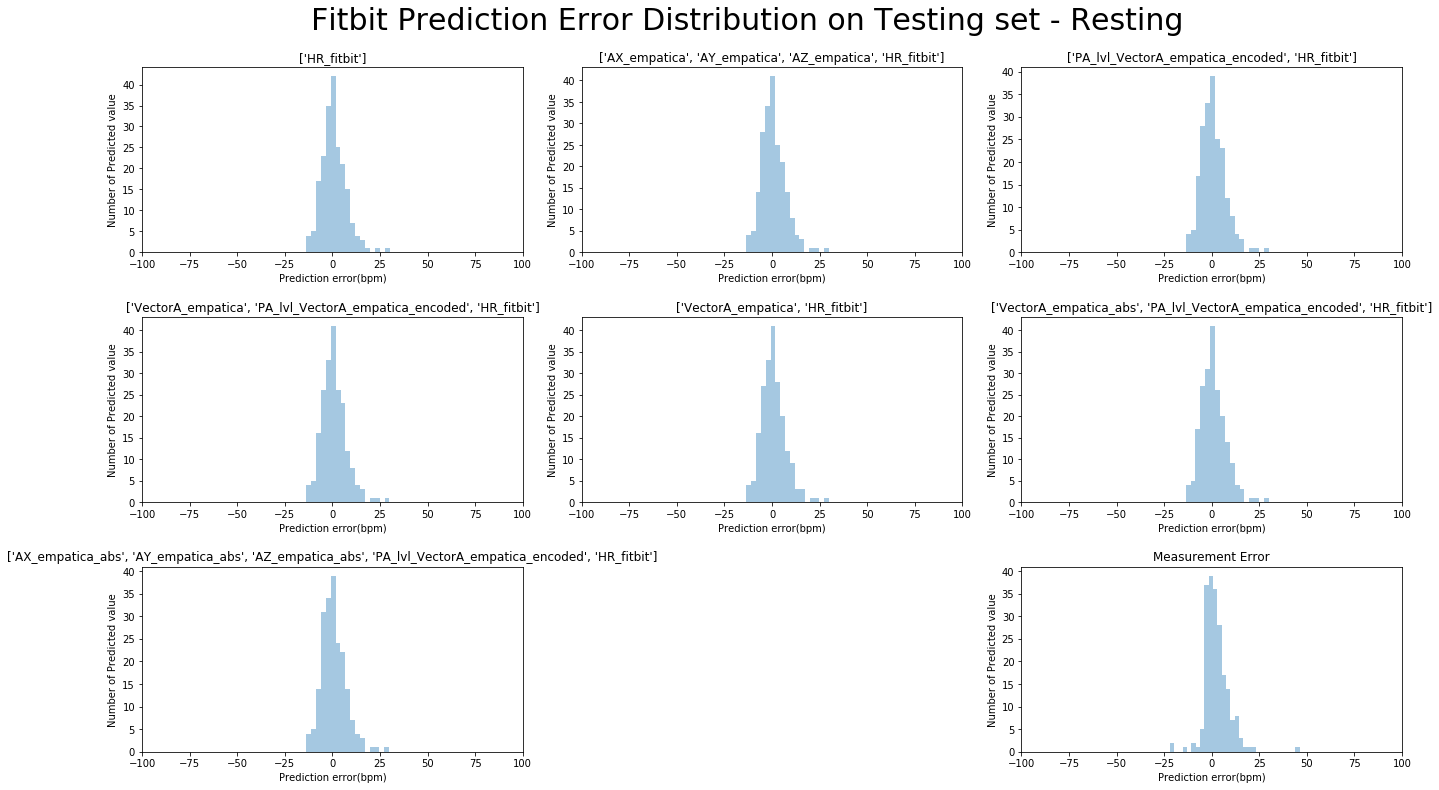

In [16]:
# Declare training features for testing the best features from best estimators on the testing set
i = 0
# Figure for each distribution plot
my_dpi = 96
fig = plt.figure(figsize=(1920/my_dpi, 1080/my_dpi))
plt.subplots_adjust(top=0.905,
bottom=0.06,
left=0.08,
right=0.955,
hspace=0.35,
wspace=0.155)
fig.suptitle('Fitbit Prediction Error Distribution on Testing set - Resting', fontsize=30)

for regressor_name, regressor in regressor_resting_dict.items():
    print("Regressor name : {0}".format(regressor_name))
    print(regressor.best_estimator_)
    #print('Target : \n{0}'.format(y_testset.values.reshape(-1)))
    y_pred = regressor.best_estimator_.predict(X_testset[features[i]].values)
    #print('Prediction : \n{0}'.format(y_pred))
    #print('Error on testing set : {0}'.format(y_testset.values - y_pred))
    mae_fitbit_results_score['testing_set']['Resting'][str(regressor_name)]['MAE_std_testingset_score'] = mean_absolute_error(y_testset.values.reshape(-1), y_pred.reshape(-1))
    mae_fitbit_results_score['testing_set']['Resting'][str(regressor_name)]['MAE_mean_testingset_score'] = np.std(np.abs(y_testset.values.reshape(-1) - y_pred.reshape(-1)))
    print('MAE on testing set : {0}'.format(mean_absolute_error(y_testset.values.reshape(-1), y_pred.reshape(-1))))
    print('MAE_STD on testing set : {0}'.format(np.std(y_testset.values.reshape(-1)-y_pred.reshape(-1))))
    
    # Plotting the Error distribution
    axes = plt.subplot(3, 3, i+1)
    axes.set(xlabel='Prediction error(bpm)', ylabel='Number of Predicted value', title=regressor_name)
    sns.distplot(y_testset.values.reshape(-1) - y_pred.reshape(-1), kde=False, ax=axes)    
    axes.set_xticks(np.arange(-100, 125, 25))    
    #print('MAE on testing set : {0}'.format(regressor.best_estimator_.score(X_testset[features[i]], y_testset.values.reshape(-1))))
    print('\n\n')
    i = i+1
    
axes = plt.subplot(3, 3, i+2)
sns.distplot(y_testset.values.reshape(-1) - X_testset['HR_fitbit'].values.reshape(-1), kde=False, ax=axes)
axes.set(xlabel='Prediction error(bpm)', ylabel='Number of Predicted value', title='Measurement Error')
axes.set_xticks(np.arange(-100, 125, 25))
fig.savefig('./ErrorDistribution_2/fitbit_resting_error_dist', dpi=96, bbox_inches='tight')    

## Sleeping state

In [17]:
# Sleeping states

# Reading all files into dataframe
sleeping_df = []
sleeping_df_training = []
sleeping_df_testing = []
X_trainingset = pd.DataFrame()
y_trainingset = pd.DataFrame()
X_testset = pd.DataFrame()
y_testset = pd.DataFrame()
for filename in dict_filename['Sleeping']:
    # Loading the dataset into dataframe
    temp_sleeping_df = pd.read_csv(filename)
    print('Filename : ' + filename)
    print('Usable data(Including Accel and Freedson) : ' + str(len(temp_sleeping_df[['HR_biosignalsplux', 'HR_fitbit', 'AX_empatica', 'AY_empatica', 'AZ_empatica', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded']].dropna())))
    
    temp_sleeping_df = temp_sleeping_df[['HR_biosignalsplux', 'HR_fitbit', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'AX_empatica', 'AY_empatica', 'AZ_empatica']].dropna()
    # Create a absolute feature from Accelerometer
    temp_sleeping_df[['VectorA_empatica_abs', 'AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs']] = np.abs(temp_sleeping_df[['VectorA_empatica', 'AX_empatica', 'AY_empatica', 'AZ_empatica']])
    X = temp_sleeping_df.loc[:, ['HR_fitbit', 'AX_empatica', 'AY_empatica', 'AZ_empatica', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'VectorA_empatica_abs', 'AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs']]
    y = temp_sleeping_df.loc[:, ['HR_biosignalsplux']]
    
    # Splitting data into training and testing set for each subject to prevent subject imbalanced
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=np.random.randint(0, 10))

    X_trainingset = X_trainingset.append(X_train, ignore_index=True)
    y_trainingset = y_trainingset.append(y_train, ignore_index=True)
    X_testset = X_testset.append(X_test, ignore_index=True)
    y_testset = y_testset.append(y_test, ignore_index=True)
    print('--->X Shape : ' + str(X.shape))
    print('--->y Shape : ' + str(y.shape))
    print('--->X_train Shape : ' + str(X_train.shape))
    print('--->y_train Shape : ' + str(y_train.shape))
    print('--->X_test Shape : ' + str(X_test.shape))
    print('--->y_test Shape : ' + str(y_test.shape))
    print('--->X_trainingset Shape : ' + str(X_trainingset.shape))
    print('--->y_trainingset Shape : ' + str(y_trainingset.shape))
    print('--->X_testset Shape : ' + str(X_testset.shape))
    print('--->y_testset Shape : ' + str(y_testset.shape))
    print('\n\n')
    sleeping_df.append(temp_sleeping_df)
  
# Final shape of training set and testing set
print('*************************************************')
print('Final shape of Training set')
print('--->X_trainingset Shape : ' + str(X_trainingset.shape))
print('--->y_trainingset Shape : ' + str(y_trainingset.shape))
print('Final shape of Testing set')
print('--->X_testset Shape : ' + str(X_testset.shape))
print('--->y_testset Shape : ' + str(y_testset.shape))
print('*************************************************')


Filename : ./Sleeping/Subject10_2019-01-31_grouped_sleeping.csv
Usable data(Including Accel and Freedson) : 455
--->X Shape : (455, 10)
--->y Shape : (455, 1)
--->X_train Shape : (364, 10)
--->y_train Shape : (364, 1)
--->X_test Shape : (91, 10)
--->y_test Shape : (91, 1)
--->X_trainingset Shape : (364, 10)
--->y_trainingset Shape : (364, 1)
--->X_testset Shape : (91, 10)
--->y_testset Shape : (91, 1)



Filename : ./Sleeping/Subject06_2019-01-25_grouped_sleeping.csv
Usable data(Including Accel and Freedson) : 374
--->X Shape : (374, 10)
--->y Shape : (374, 1)
--->X_train Shape : (299, 10)
--->y_train Shape : (299, 1)
--->X_test Shape : (75, 10)
--->y_test Shape : (75, 1)
--->X_trainingset Shape : (663, 10)
--->y_trainingset Shape : (663, 1)
--->X_testset Shape : (166, 10)
--->y_testset Shape : (166, 1)



Filename : ./Sleeping/Subject09_2019-01-30_grouped_sleeping.csv
Usable data(Including Accel and Freedson) : 489
--->X Shape : (489, 10)
--->y Shape : (489, 1)
--->X_train Shape : (39

In [18]:
# Declare training features for trying the best features
features = [['HR_fitbit'], 
           ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'], 
           ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'HR_fitbit'], 
           ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']]

# Hyperparameters settings
# Maximun depth for dividing into a new leaf
max_depth = np.arange(1, 2)
# Number of estimator for majority vote
n_estimators = [25, 50]
# Stop criteria
criterion = ['mae']

# Start training
params_dict = {'n_estimators' : n_estimators, 'criterion' : criterion, 'max_depth' : max_depth}

regressor_sleeping_dict = {}
for each_feature in features:
    print('Regressor : {0}'.format(each_feature))
    rf_regressor = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params_dict, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=True, iid=True, return_train_score=True)
    regressor_sleeping_dict[str(each_feature)] = rf_regressor.fit(X_trainingset[each_feature].values, y_trainingset.values.reshape(-1))

Regressor : ['HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.4s finished


Regressor : ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.1s finished


Regressor : ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.3s finished


Regressor : ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.8s finished


Regressor : ['VectorA_empatica', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.0s finished


Regressor : ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.2s finished


Regressor : ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   15.6s finished


In [19]:
for regressor_name, regressor in regressor_sleeping_dict.items():
    temp_cv_results_ = pd.DataFrame(regressor.cv_results_)
    #print(temp_cv_results_.loc[temp_cv_results_['params'] == regressor.best_params_].loc[:, ['mean_test_score', 'std_test_score']])
    test_score_results = temp_cv_results_.loc[temp_cv_results_['params'] == regressor.best_params_].loc[:, ['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
    print('Test score(CV) : {0}'.format(test_score_results['mean_test_score'].values[0]))
    print('Std test score(CV) : {0}'.format(test_score_results['std_test_score'].values[0]))
    mae_fitbit_results_score['validation_set']['Sleeping'][str(regressor_name)]['MAE_mean_test_score'] = test_score_results['mean_test_score'].values[0]
    mae_fitbit_results_score['validation_set']['Sleeping'][str(regressor_name)]['MAE_std_test_score'] = test_score_results['std_test_score'].values[0]
    mae_fitbit_results_score['validation_set']['Sleeping'][str(regressor_name)]['MAE_mean_train_score'] = test_score_results['mean_train_score'].values[0]
    mae_fitbit_results_score['validation_set']['Sleeping'][str(regressor_name)]['MAE_std_train_score'] = test_score_results['std_train_score'].values[0]

    print('{0} : {1}'.format(regressor_name, regressor.best_score_))
    print('\n')

Test score(CV) : -5.958706050142964
Std test score(CV) : 2.942451278579139
['HR_fitbit'] : -5.958706050142964


Test score(CV) : -5.966726519726753
Std test score(CV) : 2.9227749823410165
['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'] : -5.966726519726753


Test score(CV) : -5.968167200005741
Std test score(CV) : 2.9362964718335247
['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -5.968167200005741


Test score(CV) : -5.940188856039324
Std test score(CV) : 2.9474382658038683
['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -5.940188856039324


Test score(CV) : -5.974678795656501
Std test score(CV) : 2.902301738743521
['VectorA_empatica', 'HR_fitbit'] : -5.974678795656501


Test score(CV) : -5.940745515026546
Std test score(CV) : 2.937955890747103
['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -5.940745515026546


Test score(CV) : -5.962581658827189
Std test score(CV) : 2.941739594047322
['AX_empatica_abs', 'AY_empatica_abs

Regressor name : ['HR_fitbit']
RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=1,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAE on testing set : 5.563250428151532
MAE_STD on testing set : 9.445867469496257



Regressor name : ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit']
RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=1,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAE on testing set : 5.539254401568872
MAE

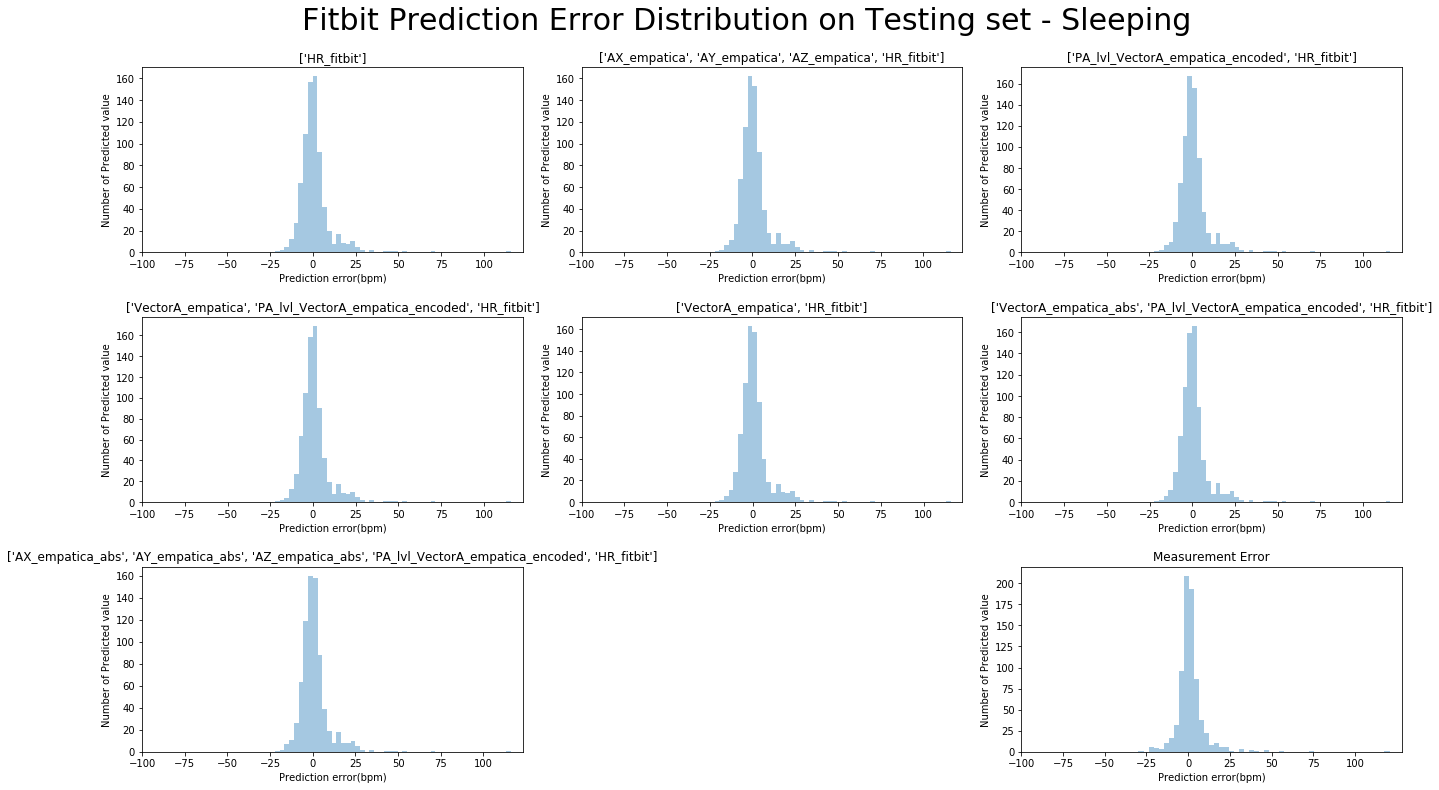

In [20]:
# Declare training features for testing the best features from best estimators on the testing set
features = [['HR_fitbit'],
           ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'], 
           ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'HR_fitbit'], 
           ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']]
# Declare training features for testing the best features from best estimators on the testing set
i = 0
# Figure for each distribution plot
my_dpi = 96
fig = plt.figure(figsize=(1920/my_dpi, 1080/my_dpi))
plt.subplots_adjust(top=0.905,
bottom=0.06,
left=0.08,
right=0.955,
hspace=0.35,
wspace=0.155)
fig.suptitle('Fitbit Prediction Error Distribution on Testing set - Sleeping', fontsize=30)

for regressor_name, regressor in regressor_sleeping_dict.items():
    print("Regressor name : {0}".format(regressor_name))
    print(regressor.best_estimator_)
    #print('Target : \n{0}'.format(y_testset.values.reshape(-1)))
    y_pred = regressor.best_estimator_.predict(X_testset[features[i]].values)
    #print('Prediction : \n{0}'.format(y_pred))
    #print('Error on testing set : {0}'.format(y_testset.values - y_pred))
    mae_fitbit_results_score['testing_set']['Sleeping'][str(regressor_name)]['MAE_std_testingset_score'] = mean_absolute_error(y_testset.values.reshape(-1), y_pred.reshape(-1))
    mae_fitbit_results_score['testing_set']['Sleeping'][str(regressor_name)]['MAE_mean_testingset_score'] = np.std(np.abs(y_testset.values.reshape(-1) - y_pred.reshape(-1)))
    print('MAE on testing set : {0}'.format(mean_absolute_error(y_testset.values.reshape(-1), y_pred.reshape(-1))))
    print('MAE_STD on testing set : {0}'.format(np.std(y_testset.values.reshape(-1)-y_pred.reshape(-1))))
    #print('MAE on testing set : {0}'.format(regressor.best_estimator_.score(X_testset[features[i]], y_testset.values.reshape(-1))))
    
    # Plotting the Error distribution
    axes = plt.subplot(3, 3, i+1)
    axes.set(xlabel='Prediction error(bpm)', ylabel='Number of Predicted value', title=regressor_name)
    sns.distplot(y_testset.values.reshape(-1) - y_pred.reshape(-1), kde=False, ax=axes)    
    axes.set_xticks(np.arange(-100, 125, 25))
    
    print('\n\n')
    i = i+1
axes = plt.subplot(3, 3, i+2)
sns.distplot(y_testset.values.reshape(-1) - X_testset['HR_fitbit'].values.reshape(-1), kde=False, ax=axes)
axes.set(xlabel='Prediction error(bpm)', ylabel='Number of Predicted value', title='Measurement Error')
axes.set_xticks(np.arange(-100, 125, 25))
fig.savefig('./ErrorDistribution_2/fitbit_sleeping_error_dist', dpi=96, bbox_inches='tight')    

## Intensity state

In [21]:
# Intensity states

# Reading all files into dataframe
intensity_df = []
X_trainingset = pd.DataFrame()
y_trainingset = pd.DataFrame()
X_testset = pd.DataFrame()
y_testset = pd.DataFrame()
for filename in dict_filename['Intensity']:
    # Loading the dataset into dataframe
    temp_intensity_df = pd.read_csv(filename)
    print('Filename : ' + filename)
    print('Usable data(Including Accel and Freedson) : ' + str(len(temp_intensity_df[['HR_polarh10', 'HR_fitbit', 'AX_empatica', 'AY_empatica', 'AZ_empatica', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded']].dropna())))
    
    temp_intensity_df = temp_intensity_df[['HR_polarh10', 'HR_fitbit', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'AX_empatica', 'AY_empatica', 'AZ_empatica']].dropna()
    # Create a absolute feature from Accelerometer
    temp_intensity_df[['VectorA_empatica_abs', 'AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs']] = np.abs(temp_intensity_df[['VectorA_empatica', 'AX_empatica', 'AY_empatica', 'AZ_empatica']])
    X = temp_intensity_df.loc[:, ['HR_fitbit', 'AX_empatica', 'AY_empatica', 'AZ_empatica', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'VectorA_empatica_abs', 'AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs']]
    y = temp_intensity_df.loc[:, ['HR_polarh10']]
    
    # Splitting data into training and testing set for each subject to prevent subject imbalanced
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=np.random.randint(0, 10))

    X_trainingset = X_trainingset.append(X_train, ignore_index=True)
    y_trainingset = y_trainingset.append(y_train, ignore_index=True)
    X_testset = X_testset.append(X_test, ignore_index=True)
    y_testset = y_testset.append(y_test, ignore_index=True)
    print('--->X Shape : ' + str(X.shape))
    print('--->y Shape : ' + str(y.shape))
    print('--->X_train Shape : ' + str(X_train.shape))
    print('--->y_train Shape : ' + str(y_train.shape))
    print('--->X_test Shape : ' + str(X_test.shape))
    print('--->y_test Shape : ' + str(y_test.shape))
    print('--->X_trainingset Shape : ' + str(X_trainingset.shape))
    print('--->y_trainingset Shape : ' + str(y_trainingset.shape))
    print('--->X_testset Shape : ' + str(X_testset.shape))
    print('--->y_testset Shape : ' + str(y_testset.shape))
    print('\n\n')
    intensity_df.append(temp_intensity_df)
  
# Final shape of training set and testing set
print('*************************************************')
print('Final shape of Training set')
print('--->X_trainingset Shape : ' + str(X_trainingset.shape))
print('--->y_trainingset Shape : ' + str(y_trainingset.shape))
print('Final shape of Testing set')
print('--->X_testset Shape : ' + str(X_testset.shape))
print('--->y_testset Shape : ' + str(y_testset.shape))
print('*************************************************')

Filename : ./Intensity/Subject01_2019-1-16_grouped_activity.csv
Usable data(Including Accel and Freedson) : 212
--->X Shape : (212, 10)
--->y Shape : (212, 1)
--->X_train Shape : (169, 10)
--->y_train Shape : (169, 1)
--->X_test Shape : (43, 10)
--->y_test Shape : (43, 1)
--->X_trainingset Shape : (169, 10)
--->y_trainingset Shape : (169, 1)
--->X_testset Shape : (43, 10)
--->y_testset Shape : (43, 1)



Filename : ./Intensity/Subject02_2019-01-17_grouped_activity.csv
Usable data(Including Accel and Freedson) : 259
--->X Shape : (259, 10)
--->y Shape : (259, 1)
--->X_train Shape : (207, 10)
--->y_train Shape : (207, 1)
--->X_test Shape : (52, 10)
--->y_test Shape : (52, 1)
--->X_trainingset Shape : (376, 10)
--->y_trainingset Shape : (376, 1)
--->X_testset Shape : (95, 10)
--->y_testset Shape : (95, 1)



Filename : ./Intensity/Subject03_2019-01-21_grouped_activity.csv
Usable data(Including Accel and Freedson) : 234
--->X Shape : (234, 10)
--->y Shape : (234, 1)
--->X_train Shape : (18

In [22]:
# Declare training features for trying the best features
features = [['HR_fitbit'],
           ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'], 
           ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'HR_fitbit'], 
           ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']]

# Hyperparameters settings
# Maximun depth for dividing into a new leaf
max_depth = np.arange(1, 2)
# Number of estimator for majority vote
n_estimators = [25, 50]
# Stop criteria
criterion = ['mae']

# Start training
params_dict = {'n_estimators' : n_estimators, 'criterion' : criterion, 'max_depth' : max_depth}

regressor_intenisty_dict = {}
for each_feature in features:
    print('Regressor : {0}'.format(each_feature))
    rf_regressor = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params_dict, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=True, iid=True, return_train_score=True)
    regressor_intenisty_dict[str(each_feature)] = rf_regressor.fit(X_trainingset[each_feature].values, y_trainingset.values.reshape(-1))

Regressor : ['HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.3s finished


Regressor : ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.9s finished


Regressor : ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.2s finished


Regressor : ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.1s finished


Regressor : ['VectorA_empatica', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.5s finished


Regressor : ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.9s finished


Regressor : ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.7s finished


In [23]:
for regressor_name, regressor in regressor_intenisty_dict.items():
    temp_cv_results_ = pd.DataFrame(regressor.cv_results_)
    #print(temp_cv_results_.loc[temp_cv_results_['params'] == regressor.best_params_].loc[:, ['mean_test_score', 'std_test_score']])
    test_score_results = temp_cv_results_.loc[temp_cv_results_['params'] == regressor.best_params_].loc[:, ['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
    print('Test score(CV) : {0}'.format(test_score_results['mean_test_score'].values[0]))
    print('Std test score(CV) : {0}'.format(test_score_results['std_test_score'].values[0]))
    mae_fitbit_results_score['validation_set']['Intensity'][str(regressor_name)]['MAE_mean_test_score'] = test_score_results['mean_test_score'].values[0]
    mae_fitbit_results_score['validation_set']['Intensity'][str(regressor_name)]['MAE_std_test_score'] = test_score_results['std_test_score'].values[0]
    mae_fitbit_results_score['validation_set']['Intensity'][str(regressor_name)]['MAE_mean_train_score'] = test_score_results['mean_train_score'].values[0]
    mae_fitbit_results_score['validation_set']['Intensity'][str(regressor_name)]['MAE_std_train_score'] = test_score_results['std_train_score'].values[0]

    print('{0} : {1}'.format(regressor_name, regressor.best_score_))
    print('\n')

Test score(CV) : -15.957622412922765
Std test score(CV) : 2.502408430710825
['HR_fitbit'] : -15.957622412922765


Test score(CV) : -16.026269560827863
Std test score(CV) : 2.3562473113546063
['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'] : -16.026269560827863


Test score(CV) : -16.02406865219586
Std test score(CV) : 2.687253868726682
['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -16.02406865219586


Test score(CV) : -15.920893488137303
Std test score(CV) : 2.6497034799148946
['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -15.920893488137303


Test score(CV) : -15.93130237253912
Std test score(CV) : 2.65925106671601
['VectorA_empatica', 'HR_fitbit'] : -15.93130237253912


Test score(CV) : -15.907279151943465
Std test score(CV) : 2.50568941765819
['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -15.907279151943465


Test score(CV) : -16.025234729934375
Std test score(CV) : 2.4888524248916912
['AX_empatica_abs', 'AY_empat

Regressor name : ['HR_fitbit']
RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=1,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAE on testing set : 14.541899999999998
MAE_STD on testing set : 18.597274600015993



Regressor name : ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit']
RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=1,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAE on testing set : 14.456760000000003


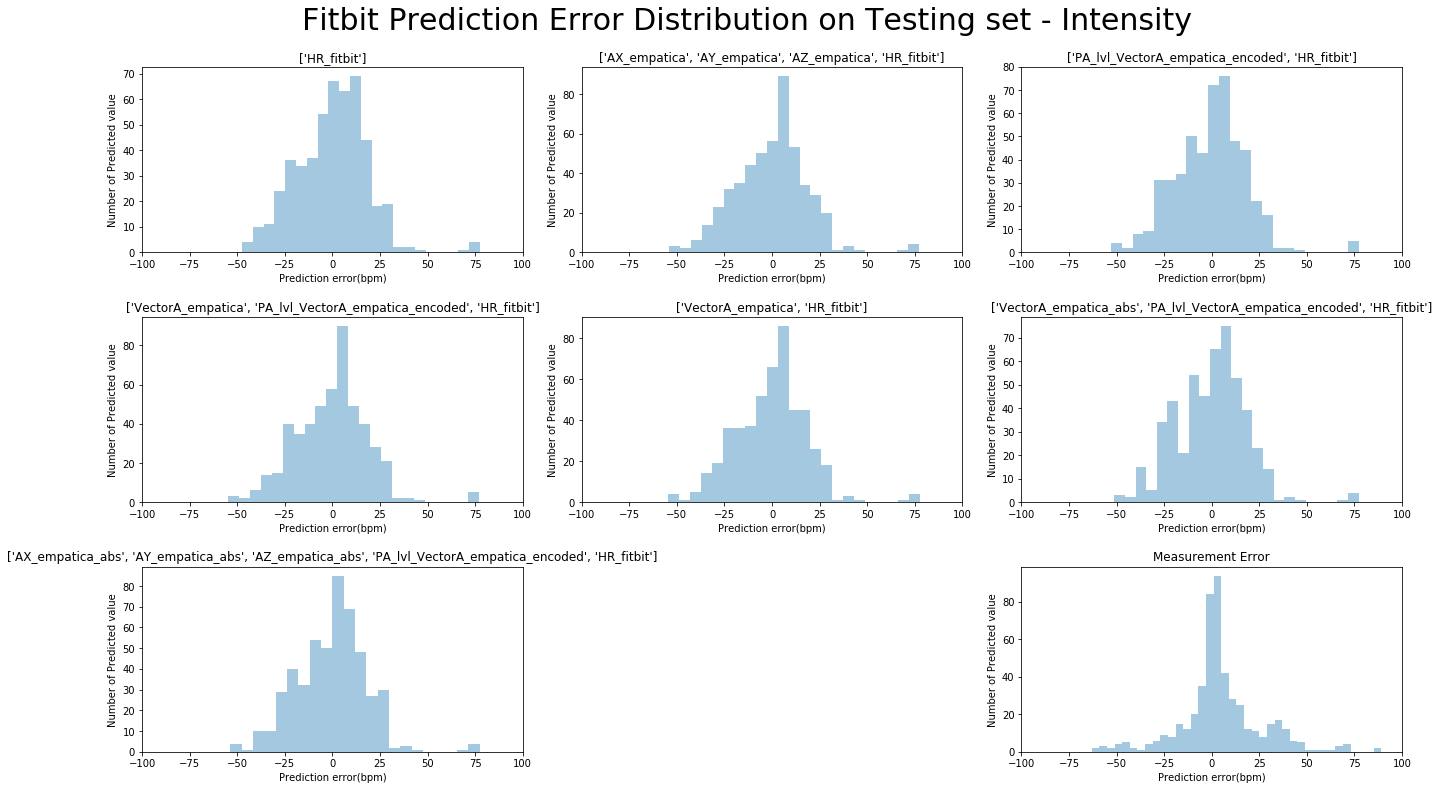

In [24]:
# Declare training features for testing the best features from best estimators on the testing set
features = [['HR_fitbit'],
           ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'], 
           ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'HR_fitbit'], 
           ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']]
# Declare training features for testing the best features from best estimators on the testing set
i = 0
# Figure for each distribution plot
my_dpi = 96
fig = plt.figure(figsize=(1920/my_dpi, 1080/my_dpi))
plt.subplots_adjust(top=0.905,
bottom=0.06,
left=0.08,
right=0.955,
hspace=0.35,
wspace=0.155)
fig.suptitle('Fitbit Prediction Error Distribution on Testing set - Intensity', fontsize=30)


for regressor_name, regressor in regressor_intenisty_dict.items():
    print("Regressor name : {0}".format(regressor_name))
    print(regressor.best_estimator_)
    #print('Target : \n{0}'.format(y_testset.values.reshape(-1)))
    y_pred = regressor.best_estimator_.predict(X_testset[features[i]].values)
    #print('Prediction : \n{0}'.format(y_pred))
    #print('Error on testing set : {0}'.format(y_testset.values - y_pred))
    mae_fitbit_results_score['testing_set']['Intensity'][str(regressor_name)]['MAE_std_testingset_score'] = mean_absolute_error(y_testset.values.reshape(-1), y_pred.reshape(-1))
    mae_fitbit_results_score['testing_set']['Intensity'][str(regressor_name)]['MAE_mean_testingset_score'] = np.std(np.abs(y_testset.values.reshape(-1) - y_pred.reshape(-1)))
    print('MAE on testing set : {0}'.format(mean_absolute_error(y_testset.values.reshape(-1), y_pred.reshape(-1))))
    print('MAE_STD on testing set : {0}'.format(np.std(y_testset.values.reshape(-1)-y_pred.reshape(-1))))
    #print('MAE on testing set : {0}'.format(regressor.best_estimator_.score(X_testset[features[i]], y_testset.values.reshape(-1))))
    
    # Plotting the Error distribution
    axes = plt.subplot(3, 3, i+1)
    axes.set(xlabel='Prediction error(bpm)', ylabel='Number of Predicted value', title=regressor_name)
    sns.distplot(y_testset.values.reshape(-1) - y_pred.reshape(-1), kde=False, ax=axes)    
    axes.set_xticks(np.arange(-100, 125, 25))    
    
    print('\n\n')
    i = i+1
    
axes = plt.subplot(3, 3, i+2)
sns.distplot(y_testset.values.reshape(-1) - X_testset['HR_fitbit'].values.reshape(-1), kde=False, ax=axes)
axes.set(xlabel='Prediction error(bpm)', ylabel='Number of Predicted value', title='Measurement Error')
axes.set_xticks(np.arange(-100, 125, 25))
fig.savefig('./ErrorDistribution_2/fitbit_intensity_error_dist', dpi=96, bbox_inches='tight')

## All states : Resting + Sleeping + Intensity

In [25]:
# All states

# Reading all files into dataframe
all_states_df = []
X_trainingset = pd.DataFrame()
y_trainingset = pd.DataFrame()
X_testset = pd.DataFrame()
y_testset = pd.DataFrame()
for filename in dict_filename['AllStates']:
    # Loading the dataset into dataframe
    temp_allstates_df = pd.read_csv(filename)
    print('Filename : ' + filename)
    
    # For resting and sleeping part
    temp_resting_sleeping = temp_allstates_df[['HR_biosignalsplux', 'HR_fitbit', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'AX_empatica', 'AY_empatica', 'AZ_empatica']].dropna()
    # Create a absolute feature from Accelerometer
    temp_resting_sleeping[['VectorA_empatica_abs', 'AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs']] = np.abs(temp_resting_sleeping[['VectorA_empatica', 'AX_empatica', 'AY_empatica', 'AZ_empatica']])
    X = temp_resting_sleeping.loc[:, ['HR_fitbit', 'AX_empatica', 'AY_empatica', 'AZ_empatica', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'VectorA_empatica_abs', 'AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs']]
    y = temp_resting_sleeping.loc[:, ['HR_biosignalsplux']]
    
    # Splitting data into training and testing set for each subject to prevent subject imbalanced
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=np.random.randint(0, 10))

    X_trainingset = X_trainingset.append(X_train, ignore_index=True)
    y_trainingset = y_trainingset.append(y_train, ignore_index=True)
    X_testset = X_testset.append(X_test, ignore_index=True)
    y_testset = y_testset.append(y_test, ignore_index=True)
    print('=>Resting and Sleeping')
    print('Usable data(Including Accel and Freedson) : ' + str(len(temp_allstates_df[['HR_biosignalsplux', 'HR_fitbit', 'AX_empatica', 'AY_empatica', 'AZ_empatica', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded']].dropna())))
    print('--->X Shape : ' + str(X.shape))
    print('--->y Shape : ' + str(y.shape))
    print('--->X_train Shape : ' + str(X_train.shape))
    print('--->y_train Shape : ' + str(y_train.shape))
    print('--->X_test Shape : ' + str(X_test.shape))
    print('--->y_test Shape : ' + str(y_test.shape))
    print('--->X_trainingset Shape : ' + str(X_trainingset.shape))
    print('--->y_trainingset Shape : ' + str(y_trainingset.shape))
    print('--->X_testset Shape : ' + str(X_testset.shape))
    print('--->y_testset Shape : ' + str(y_testset.shape))
    print('\n')

    # For Intensity
    temp_intensity = temp_allstates_df[['HR_polarh10', 'HR_fitbit', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'AX_empatica', 'AY_empatica', 'AZ_empatica']].dropna()
    # Create a absolute feature from Accelerometer
    temp_intensity[['VectorA_empatica_abs', 'AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs']] = np.abs(temp_intensity[['VectorA_empatica', 'AX_empatica', 'AY_empatica', 'AZ_empatica']])
    X = temp_intensity.loc[:, ['HR_fitbit', 'AX_empatica', 'AY_empatica', 'AZ_empatica', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'VectorA_empatica_abs', 'AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs']]
    y = temp_intensity.loc[:, ['HR_polarh10']]
    
    # Splitting data into training and testing set for each subject to prevent subject imbalanced
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=np.random.randint(0, 10))

    X_trainingset = X_trainingset.append(X_train, ignore_index=True)
    y_trainingset = y_trainingset.append(y_train, ignore_index=True)
    X_testset = X_testset.append(X_test, ignore_index=True)
    y_testset = y_testset.append(y_test, ignore_index=True)
    print('=>Intensity')
    print('Usable data(Including Accel and Freedson) : ' + str(len(temp_allstates_df[['HR_polarh10', 'HR_fitbit', 'AX_empatica', 'AY_empatica', 'AZ_empatica', 'VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded']].dropna())))
    print('--->X Shape : ' + str(X.shape))
    print('--->y Shape : ' + str(y.shape))
    print('--->X_train Shape : ' + str(X_train.shape))
    print('--->y_train Shape : ' + str(y_train.shape))
    print('--->X_test Shape : ' + str(X_test.shape))
    print('--->y_test Shape : ' + str(y_test.shape))
    print('--->X_trainingset Shape : ' + str(X_trainingset.shape))
    print('--->y_trainingset Shape : ' + str(y_trainingset.shape))
    print('--->X_testset Shape : ' + str(X_testset.shape))
    print('--->y_testset Shape : ' + str(y_testset.shape))
    print('\n')
    
    all_states_df.append(temp_allstates_df)
    
# Final shape of training set and testing set
print('*************************************************')
print('Final shape of Training set')
print('--->X_trainingset Shape : ' + str(X_trainingset.shape))
print('--->y_trainingset Shape : ' + str(y_trainingset.shape))
print('Final shape of Testing set')
print('--->X_testset Shape : ' + str(X_testset.shape))
print('--->y_testset Shape : ' + str(y_testset.shape))
print('*************************************************')


Filename : ./All_states/Subject10_2019-01-31_grouped_all_states.csv
=>Resting and Sleeping
Usable data(Including Accel and Freedson) : 600
--->X Shape : (600, 10)
--->y Shape : (600, 1)
--->X_train Shape : (480, 10)
--->y_train Shape : (480, 1)
--->X_test Shape : (120, 10)
--->y_test Shape : (120, 1)
--->X_trainingset Shape : (480, 10)
--->y_trainingset Shape : (480, 1)
--->X_testset Shape : (120, 10)
--->y_testset Shape : (120, 1)


=>Intensity
Usable data(Including Accel and Freedson) : 260
--->X Shape : (260, 10)
--->y Shape : (260, 1)
--->X_train Shape : (208, 10)
--->y_train Shape : (208, 1)
--->X_test Shape : (52, 10)
--->y_test Shape : (52, 1)
--->X_trainingset Shape : (688, 10)
--->y_trainingset Shape : (688, 2)
--->X_testset Shape : (172, 10)
--->y_testset Shape : (172, 2)


Filename : ./All_states/Subject05_2019-01-24_grouped_all_states.csv
=>Resting and Sleeping
Usable data(Including Accel and Freedson) : 722
--->X Shape : (722, 10)
--->y Shape : (722, 1)
--->X_train Shape :

In [26]:
print('X_Training set')
display(X_trainingset.head(3))
print('y_Training set')
display(y_trainingset.head(3))
display(y_trainingset.tail(3))
print('X_Testing set')
display(X_testset.head(3))
print('y_Testing set')
display(y_testset.head(3))
display(y_testset.tail(3))

X_Training set


,HR_fitbit,AX_empatica,AY_empatica,AZ_empatica,VectorA_empatica,PA_lvl_VectorA_empatica_encoded,VectorA_empatica_abs,AX_empatica_abs,AY_empatica_abs,AZ_empatica_abs
0,52.0,-0.164062,0.328125,0.335156,0.496906,2.0,0.496906,0.164062,0.328125,0.335156
1,53.0,-0.164062,0.328125,0.334766,0.496644,2.0,0.496644,0.164062,0.328125,0.334766
2,77.0,0.476562,0.109375,-0.015625,0.489202,2.0,0.489202,0.476562,0.109375,0.015625


y_Training set


,HR_biosignalsplux,HR_polarh10
0,48.910,NaN
1,57.320,NaN
2,75.385,NaN


,HR_biosignalsplux,HR_polarh10
7042,NaN,129.0
7043,NaN,142.0
7044,NaN,121.0


X_Testing set


,HR_fitbit,AX_empatica,AY_empatica,AZ_empatica,VectorA_empatica,PA_lvl_VectorA_empatica_encoded,VectorA_empatica_abs,AX_empatica_abs,AY_empatica_abs,AZ_empatica_abs
0,51.0,-0.179688,0.322591,0.332031,0.496607,2.0,0.496607,0.179688,0.322591,0.332031
1,77.0,0.246394,0.028245,0.365385,0.457148,2.0,0.457148,0.246394,0.028245,0.365385
2,75.0,0.476562,0.109730,-0.015625,0.489284,2.0,0.489284,0.476562,0.109730,0.015625


y_Testing set


,HR_biosignalsplux,HR_polarh10
0,61.54,NaN
1,87.17,NaN
2,66.79,NaN


,HR_biosignalsplux,HR_polarh10
1768,NaN,115.0
1769,NaN,142.0
1770,NaN,111.0


In [27]:
# Merging 2 columns and fillna with 0 (cause of different baseline)
y_trainingset = np.sum(y_trainingset.fillna(0).values, axis=1).reshape(-1)
y_testset = np.sum(y_testset.fillna(0).values, axis=1).reshape(-1)

In [28]:
print(y_trainingset.shape)

(7045,)


In [29]:
# Declare training features for trying the best features
features = [['HR_fitbit'],
           ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'], 
           ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'HR_fitbit'], 
           ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']]

# Hyperparameters settings
# Maximun depth for dividing into a new leaf
max_depth = np.arange(1, 2)
# Number of estimator for majority vote
n_estimators = [25, 50]
# Stop criteria
criterion = ['mae']

# Start training
params_dict = {'n_estimators' : n_estimators, 'criterion' : criterion, 'max_depth' : max_depth}

regressor_allstates_dict = {}
for each_feature in features:
    print('Regressor : {0}'.format(each_feature))
    rf_regressor = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params_dict, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=True, iid=True, return_train_score=True)
    regressor_allstates_dict[str(each_feature)] = rf_regressor.fit(X_trainingset[each_feature].values, y_trainingset.reshape(-1))

Regressor : ['HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.7s finished


Regressor : ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished


Regressor : ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   37.4s finished


Regressor : ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished


Regressor : ['VectorA_empatica', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   56.5s finished


Regressor : ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished


Regressor : ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.9min finished


In [30]:
for regressor_name, regressor in regressor_allstates_dict.items():
    temp_cv_results_ = pd.DataFrame(regressor.cv_results_)
    #print(temp_cv_results_.loc[temp_cv_results_['params'] == regressor.best_params_].loc[:, ['mean_test_score', 'std_test_score']])
    test_score_results = temp_cv_results_.loc[temp_cv_results_['params'] == regressor.best_params_].loc[:, ['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
    print('Test score(CV) : {0}'.format(test_score_results['mean_test_score'].values[0]))
    print('Std test score(CV) : {0}'.format(test_score_results['std_test_score'].values[0]))
    mae_fitbit_results_score['validation_set']['AllStates'][str(regressor_name)]['MAE_mean_test_score'] = test_score_results['mean_test_score'].values[0]
    mae_fitbit_results_score['validation_set']['AllStates'][str(regressor_name)]['MAE_std_test_score'] = test_score_results['std_test_score'].values[0]
    mae_fitbit_results_score['validation_set']['AllStates'][str(regressor_name)]['MAE_mean_train_score'] = test_score_results['mean_train_score'].values[0]
    mae_fitbit_results_score['validation_set']['AllStates'][str(regressor_name)]['MAE_std_train_score'] = test_score_results['std_train_score'].values[0]

    print('{0} : {1}'.format(regressor_name, regressor.best_score_))
    print('\n')

Test score(CV) : -14.958242034644297
Std test score(CV) : 3.800018837252335
['HR_fitbit'] : -14.958242034644297


Test score(CV) : -14.90140025178319
Std test score(CV) : 3.838978575324267
['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'] : -14.90140025178319


Test score(CV) : -14.735710437478156
Std test score(CV) : 3.5518278636074467
['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -14.735710437478156


Test score(CV) : -14.717913574502655
Std test score(CV) : 3.5759643880398118
['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -14.717913574502655


Test score(CV) : -14.882503040659833
Std test score(CV) : 3.8065172225034978
['VectorA_empatica', 'HR_fitbit'] : -14.882503040659833


Test score(CV) : -14.739682121280408
Std test score(CV) : 3.5276480450559378
['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'] : -14.739682121280408


Test score(CV) : -14.7419401895465
Std test score(CV) : 3.538112375006843
['AX_empatica_abs', 'AY_em

Regressor name : ['HR_fitbit']
RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=1,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAE on testing set : 14.824568318203076
MAE_STD on testing set : 21.273890567030698



Regressor name : ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit']
RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=1,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAE on testing set : 14.861483133092692


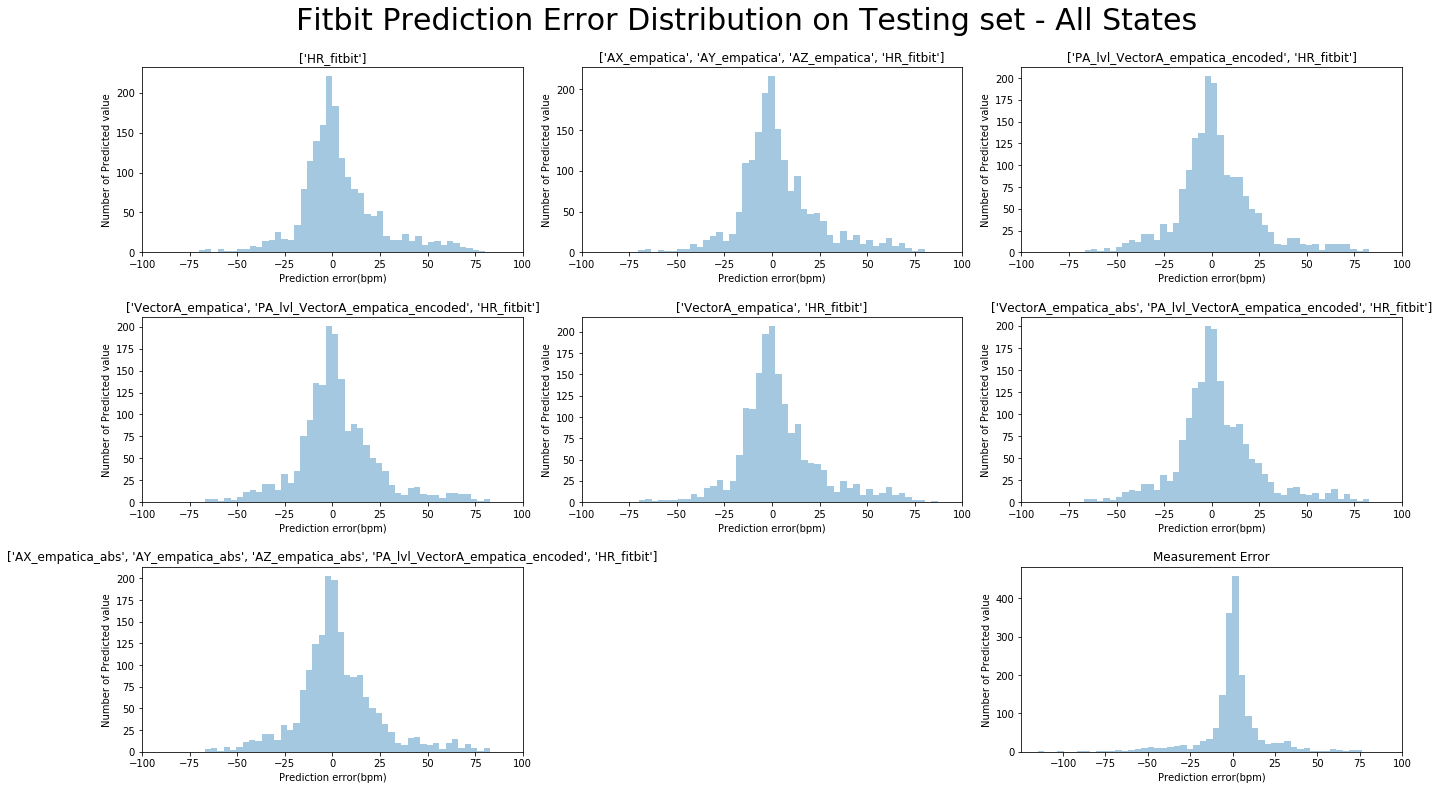

In [31]:
# Declare training features for testing the best features from best estimators on the testing set
features = [['HR_fitbit'],
           ['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit'], 
           ['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['VectorA_empatica', 'HR_fitbit'], 
           ['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit'], 
           ['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']]
# Declare training features for testing the best features from best estimators on the testing set
i = 0

# Figure for each distribution plot
my_dpi = 96
fig = plt.figure(figsize=(1920/my_dpi, 1080/my_dpi))
plt.subplots_adjust(top=0.905,
bottom=0.06,
left=0.08,
right=0.955,
hspace=0.35,
wspace=0.155)
fig.suptitle('Fitbit Prediction Error Distribution on Testing set - All States', fontsize=30)


for regressor_name, regressor in regressor_allstates_dict.items():
    print("Regressor name : {0}".format(regressor_name))
    print(regressor.best_estimator_)
    #print('Target : \n{0}'.format(y_testset.values.reshape(-1)))
    y_pred = regressor.best_estimator_.predict(X_testset[features[i]].values)
    #print('Prediction : \n{0}'.format(y_pred))
    #print('Error on testing set : {0}'.format(y_testset.values - y_pred))
    mae_fitbit_results_score['testing_set']['AllStates'][str(regressor_name)]['MAE_std_testingset_score'] = mean_absolute_error(y_testset.reshape(-1), y_pred.reshape(-1))
    mae_fitbit_results_score['testing_set']['AllStates'][str(regressor_name)]['MAE_mean_testingset_score'] = np.std(np.abs(y_testset.reshape(-1) - y_pred.reshape(-1)))
    print('MAE on testing set : {0}'.format(mean_absolute_error(y_testset.reshape(-1), y_pred.reshape(-1))))
    print('MAE_STD on testing set : {0}'.format(np.std(y_testset.reshape(-1)-y_pred.reshape(-1))))
    #print('MAE on testing set : {0}'.format(regressor.best_estimator_.score(X_testset[features[i]], y_testset.values.reshape(-1))))
    
    # Plotting the Error distribution
    axes = plt.subplot(3, 3, i+1)
    axes.set(xlabel='Prediction error(bpm)', ylabel='Number of Predicted value', title=regressor_name)
    sns.distplot(y_testset.reshape(-1) - y_pred.reshape(-1), kde=False, ax=axes)    
    axes.set_xticks(np.arange(-100, 125, 25))
    print('\n\n')
    i = i+1

axes = plt.subplot(3, 3, i+2)
sns.distplot(y_testset.reshape(-1) - X_testset['HR_fitbit'].values.reshape(-1), kde=False, ax=axes)
axes.set(xlabel='Prediction error(bpm)', ylabel='Number of Predicted value', title='Measurement Error')
axes.set_xticks(np.arange(-100, 125, 25))
fig.savefig('./ErrorDistribution_2/fitbit_allstates_error_dist', dpi=96, bbox_inches='tight')

892


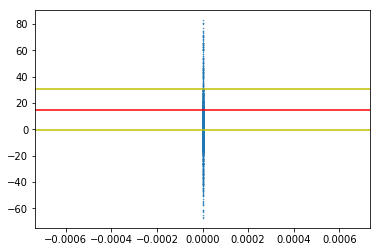

In [32]:
plt.scatter([0] * len(y_testset.reshape(-1) - y_pred.reshape(-1)), y_testset.reshape(-1) - y_pred.reshape(-1), s=0.2)
mae = np.mean(np.abs(y_testset.reshape(-1) - y_pred.reshape(-1)))
std = np.std(np.abs(y_testset.reshape(-1) - y_pred.reshape(-1)))
plt.axhline(mae, c='r')
plt.axhline(mae+std, c = 'y')
plt.axhline(mae-std, c = 'y')

print(len((y_testset.reshape(-1) - y_pred.reshape(-1))[np.where(np.abs(y_testset.reshape(-1) - y_pred.reshape(-1)) < 10)]))

In [33]:
mae_fitbit_results_score['validation_set']

{'Resting': {"['HR_fitbit']": {'MAE_mean_test_score': -5.015225207865046,
   'MAE_std_test_score': 1.1588076166459813,
   'MAE_mean_train_score': -4.885052895884931,
   'MAE_std_train_score': 0.11687306351039328},
  "['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit']": {'MAE_mean_test_score': -5.007504939616467,
   'MAE_std_test_score': 1.1215438575824015,
   'MAE_mean_train_score': -4.890960543676851,
   'MAE_std_train_score': 0.11758280462900644},
  "['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']": {'MAE_mean_test_score': -5.017768689057921,
   'MAE_std_test_score': 1.1138608423636633,
   'MAE_mean_train_score': -4.902449831618531,
   'MAE_std_train_score': 0.12087621495770892},
  "['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']": {'MAE_mean_test_score': -5.009161225849129,
   'MAE_std_test_score': 1.1102990557460821,
   'MAE_mean_train_score': -4.892584081944902,
   'MAE_std_train_score': 0.12681006662811772},
  "['VectorA_empatica', 'HR_fitbit']": {'M

In [34]:
mae_fitbit_results_score['testing_set']

{'Resting': {"['HR_fitbit']": {'MAE_std_testingset_score': 4.8306679685116185,
   'MAE_mean_testingset_score': 4.249061431776484},
  "['AX_empatica', 'AY_empatica', 'AZ_empatica', 'HR_fitbit']": {'MAE_std_testingset_score': 4.7602244391515045,
   'MAE_mean_testingset_score': 4.222023208748053},
  "['PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']": {'MAE_std_testingset_score': 4.78495029587853,
   'MAE_mean_testingset_score': 4.2244351203861585},
  "['VectorA_empatica', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']": {'MAE_std_testingset_score': 4.777517301836911,
   'MAE_mean_testingset_score': 4.225799176754794},
  "['VectorA_empatica', 'HR_fitbit']": {'MAE_std_testingset_score': 4.782880135800131,
   'MAE_mean_testingset_score': 4.25003816990805},
  "['VectorA_empatica_abs', 'PA_lvl_VectorA_empatica_encoded', 'HR_fitbit']": {'MAE_std_testingset_score': 4.807588059069097,
   'MAE_mean_testingset_score': 4.283324377357209},
  "['AX_empatica_abs', 'AY_empatica_abs', 'AZ_empatica_abs',

In [35]:
# Writing results to txt file
import json

with open('./mae_fitbit_results_score_mock.txt', 'w') as file:
     file.write(json.dumps(mae_fitbit_results_score)) # use `json.loads` to do the reverse